<a href="https://colab.research.google.com/github/danifeerrer/capstone_project/blob/cnn/Copia_de_BrainTumorCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import all the necessary libraries for the project**

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import ipywidgets as widgets
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle



This function will create more images, similar to the ones we already have. This is done to improve the effectiveness of the CNN

In [153]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
target_size = (150, 150)

X_data = []
y_data = []
X_data_folder = []
y_data_folder = []


train_imgs_per_folder = 900
test_imgs_per_folder = 150
number_files = 0

def fillDirectory(number_files, X_data_folder, y_data_folder, total_images):
    print("Number of files in folder:", number_files)
    print("Data images required per folder:", total_images)
    print("Folder length:", len(X_data_folder))

    augmented_X_train = []
    augmented_y_train = []

    # Generate augmented images for a batch
    batch_size = total_images - number_files
    print("Batch size:", batch_size)

    datagen_subfolder = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',

    )

    # Generate augmented images for this subfolder
    for _ in range(batch_size):
        # Randomly select an image from the subfolder
        random_index = np.random.randint(0, len(X_data_folder))
        image = X_data_folder[random_index]



        # Apply data augmentation to the selected image
        augmented_image = datagen_subfolder.random_transform(image)

        augmented_image = cv2.resize(augmented_image, target_size, interpolation=cv2.INTER_AREA)
        # Append the augmented image and its label
        augmented_X_train.append(augmented_image)
        augmented_y_train.append(y_data_folder[random_index])

    augmented_X_train = np.array(augmented_X_train)
    augmented_y_train = np.array(augmented_y_train)
    X_data_folder.extend(augmented_X_train)
    y_data_folder.extend(augmented_y_train)

We start looking at the data, and transforming all images to a same
size of 150 pixels, and appending all the sized images to the new X_train list. Then, we convert the list into a np array.


In [154]:

# Loop through both training and testing directories
for directory in ['Training', 'Testing']:
    for label in labels:
        folderPath = os.path.join('./drive/MyDrive', directory, label)
        number_files = 0  # Reset number_files for each subfolder

        # Iterate through image files in the folder
        for filename in tqdm(os.listdir(folderPath)):
            img_path = os.path.join(folderPath, filename)
            number_files += 1

            # Read the image using OpenCV
            image = cv2.imread(img_path)

            # Resize the image to the target size
            image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

            # Append the image and label to the lists
            X_data_folder.append(image)
            y_data_folder.append(label)

        # Check if additional images need to be generated for this subfolder
        if directory == "Training" and number_files < train_imgs_per_folder:
            fillDirectory(number_files, X_data_folder, y_data_folder, train_imgs_per_folder)

        elif directory == "Testing" and number_files < test_imgs_per_folder:
            fillDirectory(number_files, X_data_folder, y_data_folder, test_imgs_per_folder)

        X_data.extend(X_data_folder)
        y_data.extend(y_data_folder)
        X_data_folder = []
        y_data_folder = []


# Convert the lists to NumPy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)


100%|██████████| 826/826 [00:06<00:00, 131.26it/s]


Number of files in folder: 826
Data images required per folder: 900
Folder length: 826
Batch size: 74


100%|██████████| 395/395 [00:02<00:00, 178.44it/s]


Number of files in folder: 395
Data images required per folder: 900
Folder length: 395
Batch size: 505


100%|██████████| 822/822 [00:05<00:00, 141.18it/s]


Number of files in folder: 822
Data images required per folder: 900
Folder length: 822
Batch size: 78


100%|██████████| 827/827 [00:06<00:00, 128.24it/s]


Number of files in folder: 827
Data images required per folder: 900
Folder length: 827
Batch size: 73


100%|██████████| 100/100 [00:00<00:00, 170.95it/s]


Number of files in folder: 100
Data images required per folder: 150
Folder length: 100
Batch size: 50


100%|██████████| 105/105 [00:00<00:00, 282.41it/s]


Number of files in folder: 105
Data images required per folder: 150
Folder length: 105
Batch size: 45


100%|██████████| 115/115 [00:00<00:00, 206.01it/s]


Number of files in folder: 115
Data images required per folder: 150
Folder length: 115
Batch size: 35


100%|██████████| 74/74 [00:00<00:00, 93.06it/s]


Number of files in folder: 74
Data images required per folder: 150
Folder length: 74
Batch size: 76


Let's take a look at the new created Brain MRI images, with the help of the matplot library.

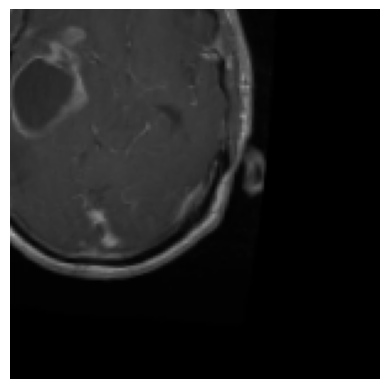

In [155]:
import matplotlib.pyplot as plt

# Access the image at index 865
image = X_data[897]

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels and ticks
plt.show()


Now we will split the data into training and testing sections using the train_test_split function

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


y_data[y_data != "no_tumor"] = "tumor"


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)



Let's import the necessary libraries to declare the CNN model and define it.

In [157]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
model = keras.Sequential([
    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten layer
    layers.Flatten(),

    # Dense (fully connected) layers
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Output layer with 2 classes (tumor or no tumor)
])

Now it's time to compile the model, train it and evaluate its accuracy.

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/5
105/105 [==============================] - 37s 349ms/step - loss: 32.6283 - accuracy: 0.7646 - val_loss: 0.3689 - val_accuracy: 0.8536
Epoch 2/5
105/105 [==============================] - 34s 326ms/step - loss: 0.2381 - accuracy: 0.8958 - val_loss: 0.3586 - val_accuracy: 0.8583
Epoch 3/5
105/105 [==============================] - 35s 334ms/step - loss: 0.1153 - accuracy: 0.9571 - val_loss: 0.2935 - val_accuracy: 0.8988
Epoch 4/5
 71/105 [===================>..........] - ETA: 10s - loss: 0.0494 - accuracy: 0.9872